# Detecting Emotions in Headlines

## Exploratory Data Analysis

Author: Kelly Epley


In this notebook, I explore the class distributions and word frequencies in the SemEval 2007 Task 14 [dataset](http://web.eecs.umich.edu/~mihalcea/affectivetext/). In the process, I illustrate some of the challenges associated with identifying emotions in text.


### Organization

I used a custom function to organize the data into a corpus DataFrame and two sets of targets: emotions and valences. See the file named "get_labeled_dfs" for details.

The emotion target is a set of intensity ratings for six emotion categories on a scale of 0 to 100. The categories are: anger, disgust, fear, joy, sadness, and surprise. The valence target is a single valence rating between -100 and 100. 

I added a "label" column to each target DataFrame. The labels in "emotion_df" represent the emotion with the highest intensity rating for each headline. The labels in "valence_df" represent negative ratings beween -100 and -15, positive raings between 15 and 100, and low valence/neutral ratings in the middle. 


In [1]:
# import all necessary packages and custom functions, classes
import pandas as pd
import numpy as np

from nltk.util import bigrams

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *
from get_emotion_wordcount import *
from get_pos_neg_wordcount import *

In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [6]:
corpus_df.head()


,text
0,Test to predict breast cancer relapse is approved
1,"Two Hussein allies are hanged, Iraqi official ..."
2,Sights and sounds from CES
3,Schuey sees Ferrari unveil new car
4,Closings and cancellations top advice on flu o...


In [7]:
valence_df.head()


,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [8]:
emotion_df.head()


,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Length of Headlines

The headlines in the datasets are all relatively short with an average length of five words and a maximum of ten.

In [9]:
lengths = []
for i in corpus_df['text']:
    lengths.append(len(i.split()))
    
print("The average headline length is {0} words.".format(np.round(sum(lengths)/len(lengths), 2)))
print("The shortest headline length is {0} words.".format(min(lengths)))
print("The longest headline length is {0} words.".format(max(lengths)))

The average headline length is 6.49 words.
The shortest headline length is 2 words.
The longest headline length is 15 words.


## Label Distributions 

The emotion and valence classes are both imbalanced. Of the emotion classes, disgust and anger are much smaller, and joy is much larger. The positive and negative classes are similar sizes, but the neutral class is comparatively small.

Text(0.5, 1.0, 'Number of Headlines per Valence Category')

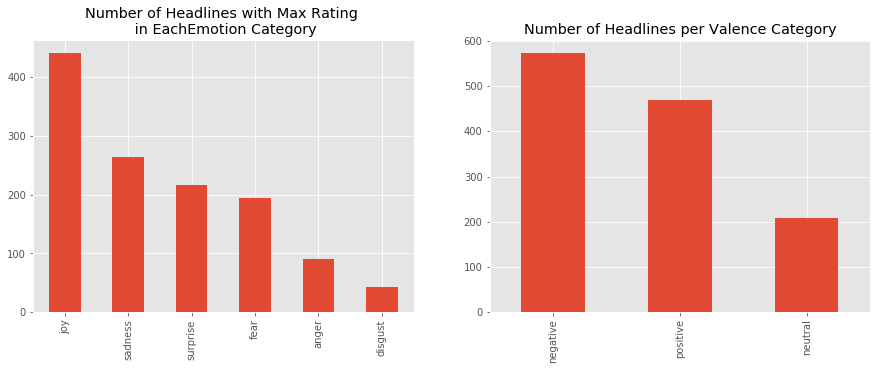

In [10]:
# create bar charts showing headline counts for each category
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
emotion_df['max'].value_counts().plot(kind='bar')
plt.title("Number of Headlines with Max Rating \n in EachEmotion Category")

plt.subplot(1,2,2)
valence_df['label'].value_counts().plot(kind='bar')
plt.xticks([0,1,2], ["negative", "positive", "neutral"])
plt.title("Number of Headlines per Valence Category")


## Label Correlations

As you might expect, there are positive correlations between:

* disgust and anger
* sadness and fear
* fear and anger

There are negative correlations between:

* joy and sadness
* joy and fear
* joy and anger

Text(0.5, 1.0, 'Correlations Among Emotion Categories')

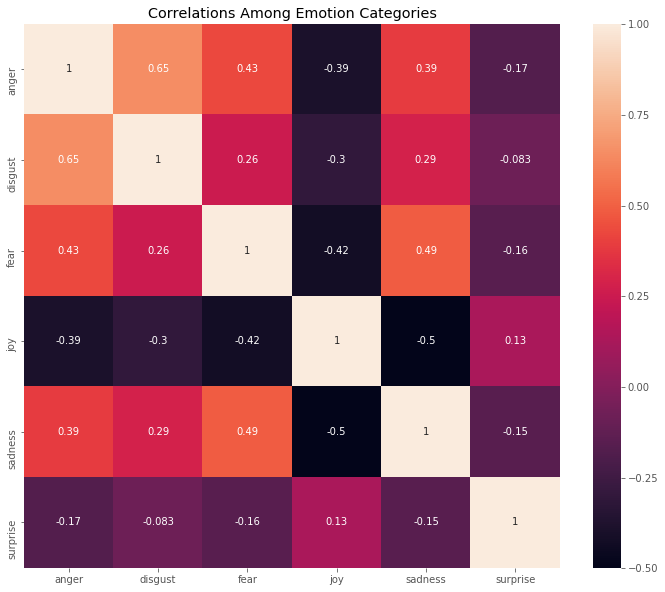

In [11]:
# correlations among emotion categories
plt.figure(figsize=(12,10))
corr = emotion_df.iloc[:,:6].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.title('Correlations Among Emotion Categories')

## Intensity Distributions

There are notable differences in the distribution of intensity ratings among the emotions. 

The valence distributions have means roughly in the middle of their respective ranges.

Text(0.5, 1.0, 'Distributions of Intensity for Each Emotion')

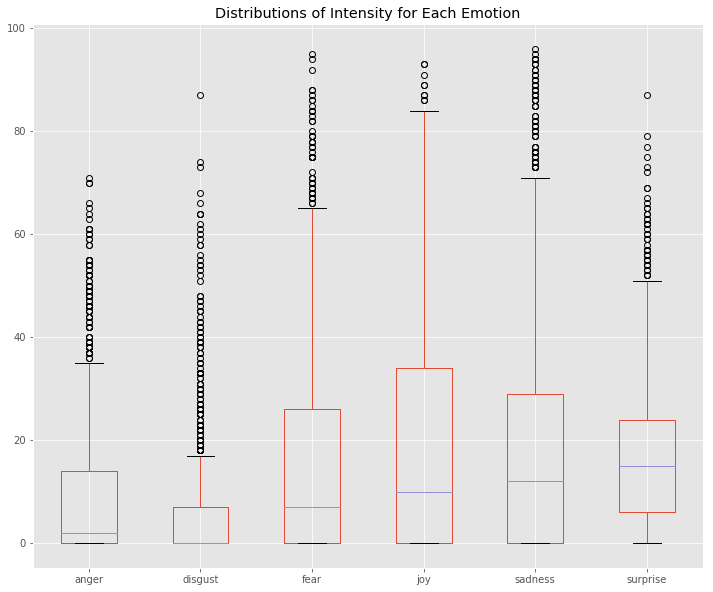

In [12]:
# boxplot showing the disribution of intensity scores for each emotion
plt.figure(figsize=(12,10))
emotion_df.iloc[:,:6].boxplot()
plt.title("Distributions of Intensity for Each Emotion")

Text(0.5, 0.98, 'Distributions of Intensity for Valence Classes')

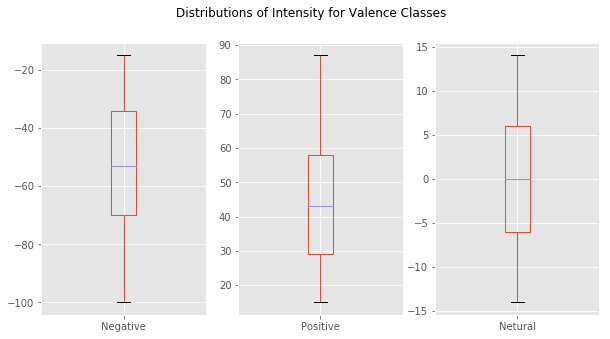

In [13]:
# boxplot showing the disribution of valence scores 
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
valence_df.loc[valence_df['label']==0]['valence'].plot(kind='box')
plt.xticks([1], labels=["Negative"])
plt.subplot(1,3,2)
valence_df.loc[valence_df['label']==1]['valence'].plot(kind='box')
plt.xticks([1], labels=["Positive"])
plt.subplot(1,3,3)
valence_df.loc[valence_df['label']==2]['valence'].plot(kind='box')
plt.xticks([1], labels=["Netural"])
plt.suptitle("Distributions of Intensity for Valence Classes")


In [14]:
# note that there there are a few rows with rating 0 for valence, 
print("Number of rows with 0 valence rating:", len(valence_df.loc[(valence_df.valence==0)]))

Number of rows with 0 valence rating: 15


## Presence of Emotion Words

One obvious strategy for detecting emotions in text is to look for the presence of emotion words such as "happy," "sad," and "afraid."

To explore this strategy, I used an emotion lexicon from WordNet ([described here](http://wndomains.fbk.eu/wnaffect.html)) which contains lists of words corresponding to the basic emotion categories. I counted instances of emotion words in each headline to see whether the words in the lexicon correspond to the headlines' emotion ratings.

Here are a few examples of what I found:

* Sometimes the words in the lists correspond a headline's emotion rating: 

The words "tirade" and "outrage" and from the anger words list appear in the headline "Israeli woman's tirade spurs PM outrage," which received a score of 71 for anger.

* Sometimes the words in the lists *do not* align with a headline's emotion rating: 

The word "aggressive" from the anger list appears in the headline "Bigger, more aggressive rats infesting UK," which received only a 4 for anger. It's highest scores were 56 for fear and 54 for disgust. 

* Sometimes words appearing in the emotion word lists have alternative meanings that are neutral or have different emotional import: 

The word "offensive" from the disgust list appears in the headline "US to urge Nato Afghan spring offensive." The word "offensive" in this headline means: taking an action against an opponent. It presumably appears in the disgust list for its other meaning: causing someone to be insulted by a slight or a breach of social expectations. The headline receives its highest rating of 54 for fear. 

This illustrates the fact that the emotions expressed by a text are highly context-sensitive. "Aggressive" might be used to describe someone who is angry, but it might also be used to indicate that someone or something is fearsome.

It's also important to note that more than 900 of the 1000 headlines from the dataset contain no words from the emotion word lists, and yet most of these are rated as having detectable emotions and emotional valence.

Accordingly, the lists' author's caution: "All words can potentially convey affective meaning." Emotions can be conveyed in word choice without making direct reference to emotions.

From this we learn that detecting emotions in this dataset will not simply be a matter of finding emotion words.

In [15]:
# get df containing counts of words appearing in emotion word lists
emotion_wordcount = get_emotion_wordcount()

In [16]:
# view headlines containing words from the anger word list
emotion_wordcount.loc[emotion_wordcount['anger_count']>0]['text'].head()

216      Israeli woman's tirade spurs PM outrage
267    Bigger, more aggressive rats infesting UK
648                  One search does not fit all
759            'WarioWare,' Wii make perfect fit
987            Roddick, Murray score in San Jose
Name: text, dtype: object

In [17]:
# view headlines containing words from the disgust word list
emotion_wordcount.loc[emotion_wordcount['disgust_count']>0]['text'].head()

109    US to urge Nato Afghan spring offensive
Name: text, dtype: object

In [18]:
# view headlines containing words from the fear word list
emotion_wordcount.loc[emotion_wordcount['fear_count']>0]['text'].head()

33        TBS to pay $2M fine for ad campaign bomb scare
140                      Firms on alert for letter bombs
234    Memo from Frankfurt: Germany relives 1970s ter...
292    Freed Muslim terror suspect says Britain is "p...
300    In rigorous test, talk therapy works for panic...
Name: text, dtype: object

In [19]:
# view headlines containing words from the joy word list
emotion_wordcount.loc[emotion_wordcount['joy_count']>0]['text'].head()

0     Test to predict breast cancer relapse is approved
16                    Asian nations urge Myanmar reform
35                     Discovered boys bring shock, joy
43    Protesters end strike as Nepal PM concedes dem...
67              Google executive acts as goodwill envoy
Name: text, dtype: object

In [20]:
# view headlines containing words from the sadness word list
emotion_wordcount.loc[emotion_wordcount['sadness_count']>0]['text'].head()

31     Really?: The claim: the pill can make you put ...
89                Walters on Trump: 'Poor, pathetic man'
150                   BP CEO Browne to step down in June
191                 Snow brings travel misery to England
295                  Why gas follows oil up but not down
Name: text, dtype: object

In [21]:
# headlines containing words from the surprise word list
emotion_wordcount.loc[emotion_wordcount['surprise_count']>0]['text'].head()

534                    Czechs, Poles get missile warning
602              Thousands line up to get late flu shots
608    Whether to save cord blood can be puzzle for p...
672                'Grey's,' 'Betty,' 'Scrubs' get boost
714             Area should get 3-5 inches of snow today
Name: text, dtype: object

In [22]:
# check the number of headlines containing no words from any of the emotion word lists
len(emotion_wordcount.loc[(emotion_wordcount['anger_count']==0) & (emotion_wordcount['disgust_count']==0) & (emotion_wordcount['fear_count']==0) & (emotion_wordcount['joy_count']==0) & (emotion_wordcount['sadness_count']==0) & (emotion_wordcount['surprise_count']==0)])


904

# Presence of Positive/Negative Words

Another lexicon worth exploring is the [General Inquirer Category Listsing](http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm), which contains lists of positive and negatively valenced words. 

Again, the presence of positive and negative words does not perfectly track the valence of the headline. The word "hope" from the positive word list appears in the headlines, "Press sees hope in Mecca talks," which accords with it's positive valence score of 55. By contrast, the word "allies" from the positive word list appears in a headline with a negative valence rating of -48: "Two Hussein allies are hanged, Iraqi officials say." Context matters in this case because the allies in question are being held accountable for crimes commited. 


In [23]:
# get df containing counts of words appearing in positive and negative word lists
pos_neg_wordcount = get_pos_neg_wordcount()

In [24]:
# headlines containing words from the positive word list
pos_neg_wordcount.loc[pos_neg_wordcount['positive_count']>0]['text'].head()

1     Two Hussein allies are hanged, Iraqi official ...
12           Defense to challenge Russert's credibility
26                       Press sees hope in Mecca talks
30           Johnny Depp to make movie of spy poisoning
31    Really?: The claim: the pill can make you put ...
Name: text, dtype: object

In [25]:
# headlines containing words from the negative word list
pos_neg_wordcount.loc[pos_neg_wordcount['negative_count']>0]['text'].head()

0     Test to predict breast cancer relapse is approved
4     Closings and cancellations top advice on flu o...
5                   Trucks swallowed in subway collapse
12           Defense to challenge Russert's credibility
14                               CIA leak trial summary
Name: text, dtype: object

In [26]:
# check the number of headlines containing words from neither the positive nor the negative word lists
len(pos_neg_wordcount.loc[(pos_neg_wordcount['positive_count']==0) & (pos_neg_wordcount['negative_count']==0)])   

517

## Word Frequencies

Since many of the headlines do not contain emotion words, we can look for other patterns of emotion-relevance among the words they contain.

I looked at the most frequently used words and bigrams (two word pairs) in the whole document, and then the most frequently used words per category.

First, I trimmed the headlines of stopwords: insignificant words such as articles and prepositions. I also removed punctuation and numbers. Then I lemmatized words, reducing words like "going," "gone," and "went" to the root word "go."


In [27]:
# use custom class method to process text
processor = Process_Text_Data()
processor.transform(corpus_df)


### Corpus Top Words

In [28]:
# make a dictionary with words as keys and word counts as values
word_count_dict = {}

voc = set()
for row in corpus_df['text']:
    for word in row.split():
        voc.add(word)
        
for word in voc:
    word_count_dict[word]=0
    
for row in corpus_df['text']:
    for word in row.split():
        word_count_dict[word]+=1
        
# make a df of word counts        
word_count_df = pd.DataFrame({"word": [key for key in word_count_dict.keys()], "count": [val for val in word_count_dict.values()]})
word_count_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Most Frequently Used Words')

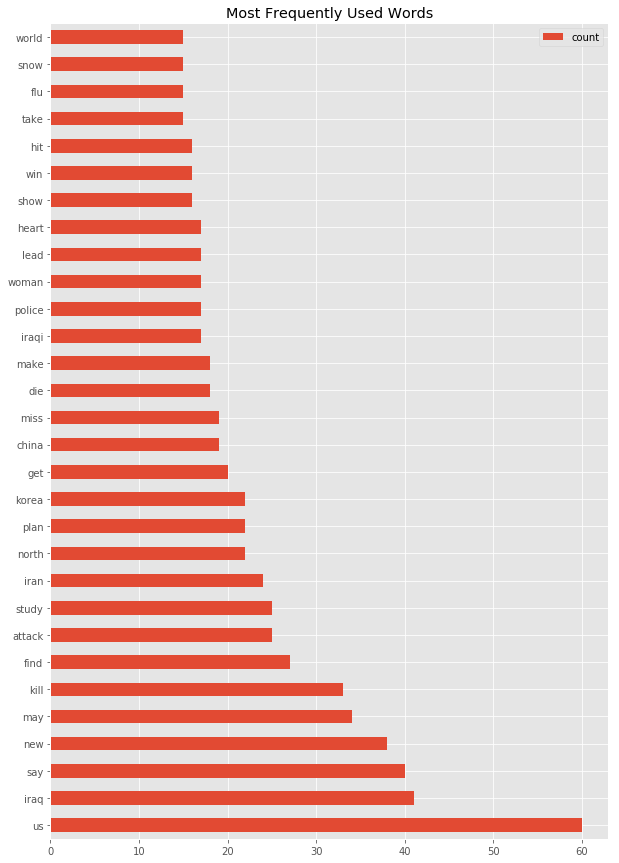

In [29]:
# plot the 30 most used words in the corpus
word_count_df[:30].plot(kind='barh', figsize=(10,15))
labels = [i for i in word_count_df[:30]['word']]
plt.yticks(ticks = range(30), labels = labels)
plt.title("Most Frequently Used Words")


### Corpus Top Bigrams

In [30]:
bigram_count_dict = {}

bigrams_set = set()
for row in corpus_df['text']:
    for bigram in list(bigrams(row.split())):
        bigrams_set.add(bigram)
        
        
for bigram in bigrams_set:
    bigram_count_dict[bigram]=0
    
for row in corpus_df['text']:
    for bigram in list(bigrams(row.split())):
        bigram_count_dict[bigram]+=1
        
# make a df of bigram counts        
bigram_count_df = pd.DataFrame({"bigram": [key for key in bigram_count_dict.keys()], "count": [val for val in bigram_count_dict.values()]})
bigram_count_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Most Frequently Used Bigrams')

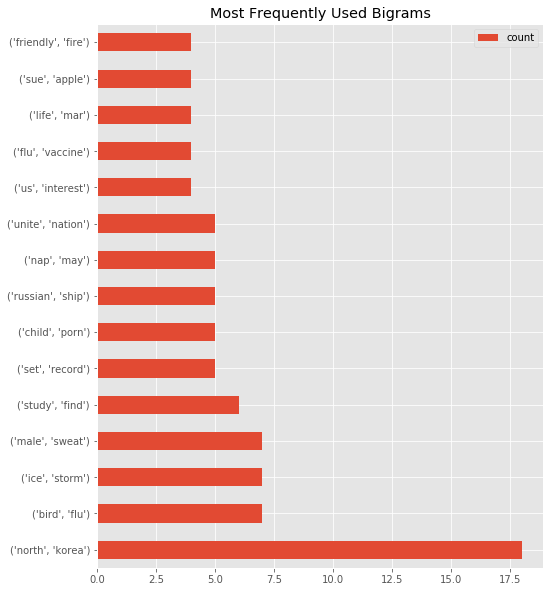

In [31]:
bigram_count_df[:15].plot(kind='barh', figsize=(8,10))
labels = [i for i in bigram_count_df[:15]['bigram']]
plt.yticks(ticks = range(15), labels = labels)
plt.title("Most Frequently Used Bigrams")

### Top Words Per Max Emotion Label

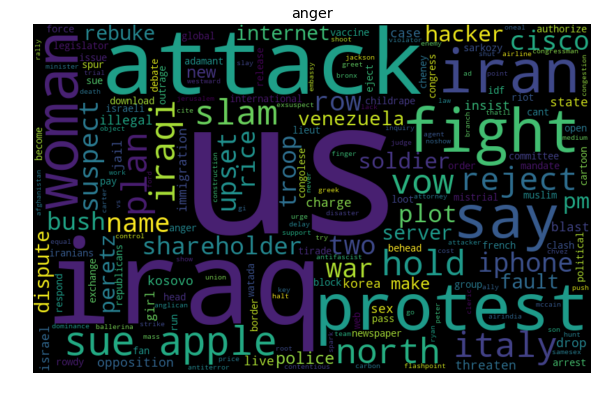

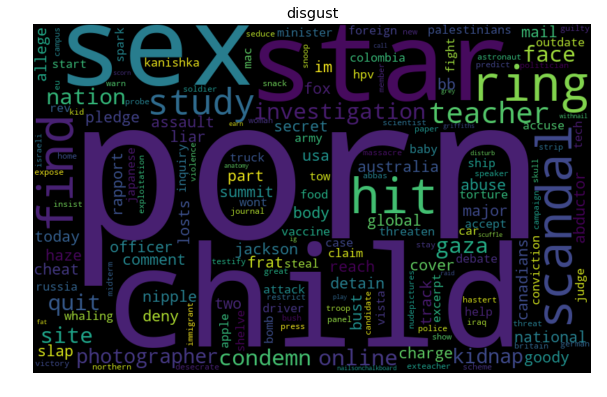

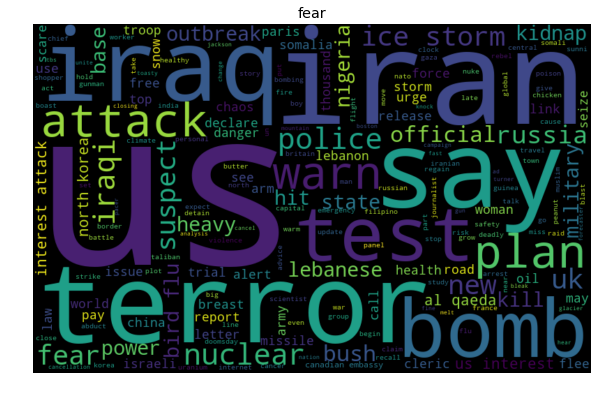

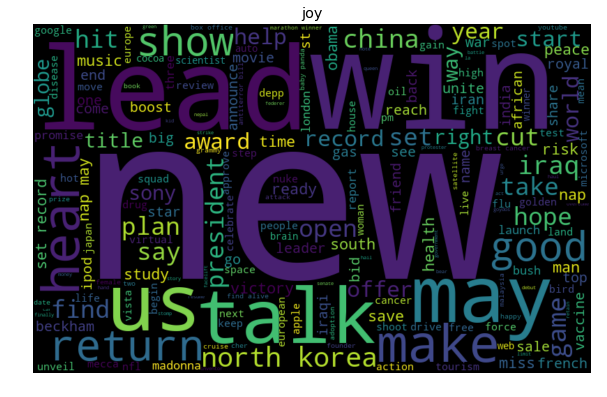

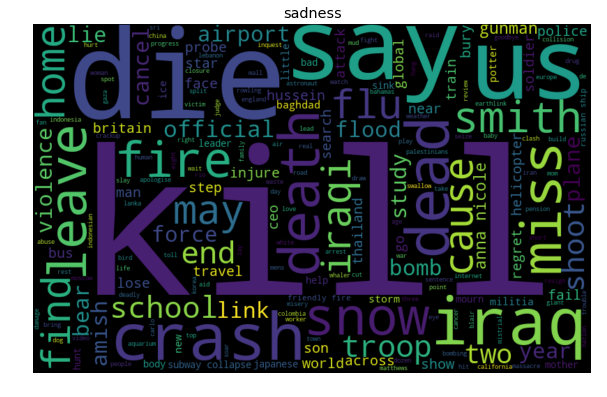

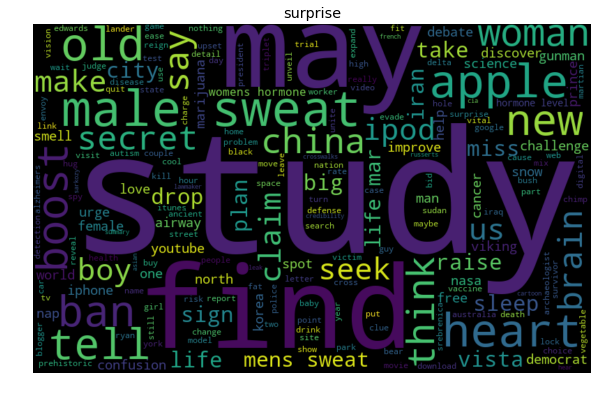

In [32]:
for i in list(emotion_df.columns[0:6]):
    
    indexes = []
    for index, val in enumerate(emotion_df['max']):
        if val==i:
            indexes.append(index)
    
    single_emotion = corpus_df['text'][indexes] 
    word_string = ' '.join([str(i) for i in single_emotion])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


### Top Words Per Valence Label

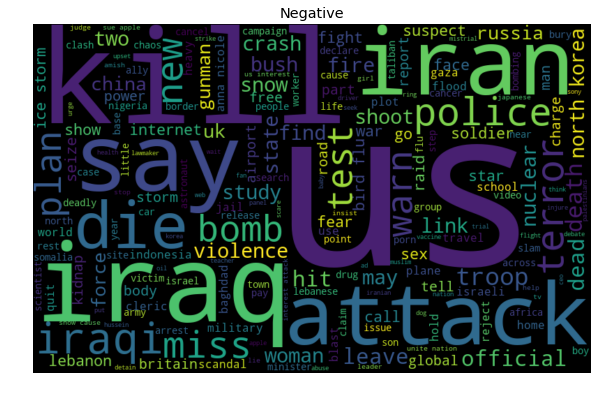

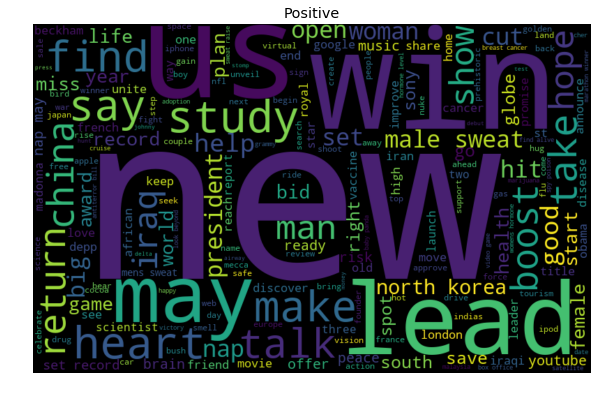

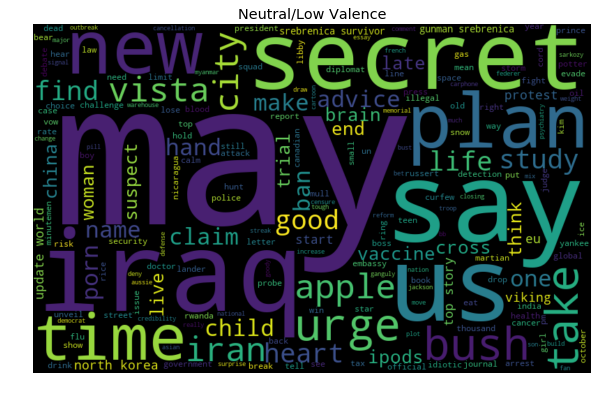

In [33]:
for i in [0,1,2]:
    
    indexes = []
    for index, val in enumerate(valence_df['label']):
        if val==i:
            indexes.append(index)
    
    single_valence = corpus_df['text'][indexes] 
    word_string = ' '.join([str(i) for i in single_valence])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    
    if i==0:
        plt.title("Negative")
    elif i==1:
        plt.title("Positive")
    else:
        plt.title("Neutral/Low Valence")
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()